In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df=pd.read_csv('processed_sales.csv')
df.head()

,date,weekday,cups_sold,weekday_num
0,2024-03-01,Friday,11,4
1,2024-03-02,Saturday,7,5
2,2024-03-03,Sunday,10,6
3,2024-03-04,Monday,4,0
4,2024-03-05,Tuesday,9,1


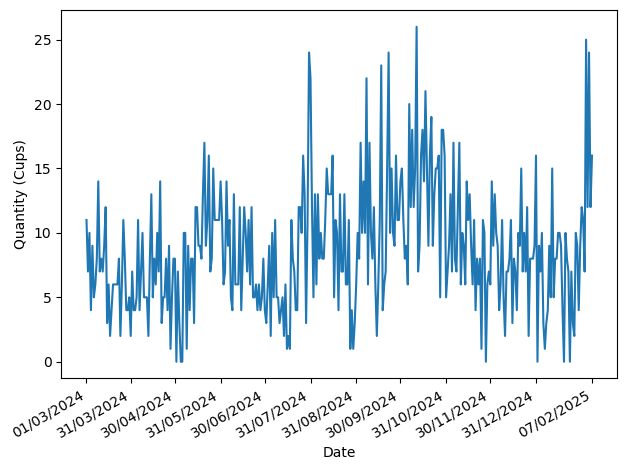

In [5]:
fig,ax=plt.subplots()

ax.plot(df['cups_sold'])
ax.set_xlabel('Date')
ax.set_ylabel('Quantity (Cups)')

plt.xticks([0,30,60,91,121,152,183,213,244,274,305,343], ['01/03/2024','31/03/2024','30/04/2024','31/05/2024','30/06/2024','31/07/2024','31/08/2024','30/09/2024','31/10/2024','30/11/2024','31/12/2024','07/02/2025'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('data_plot_primary.png', dpi=300)

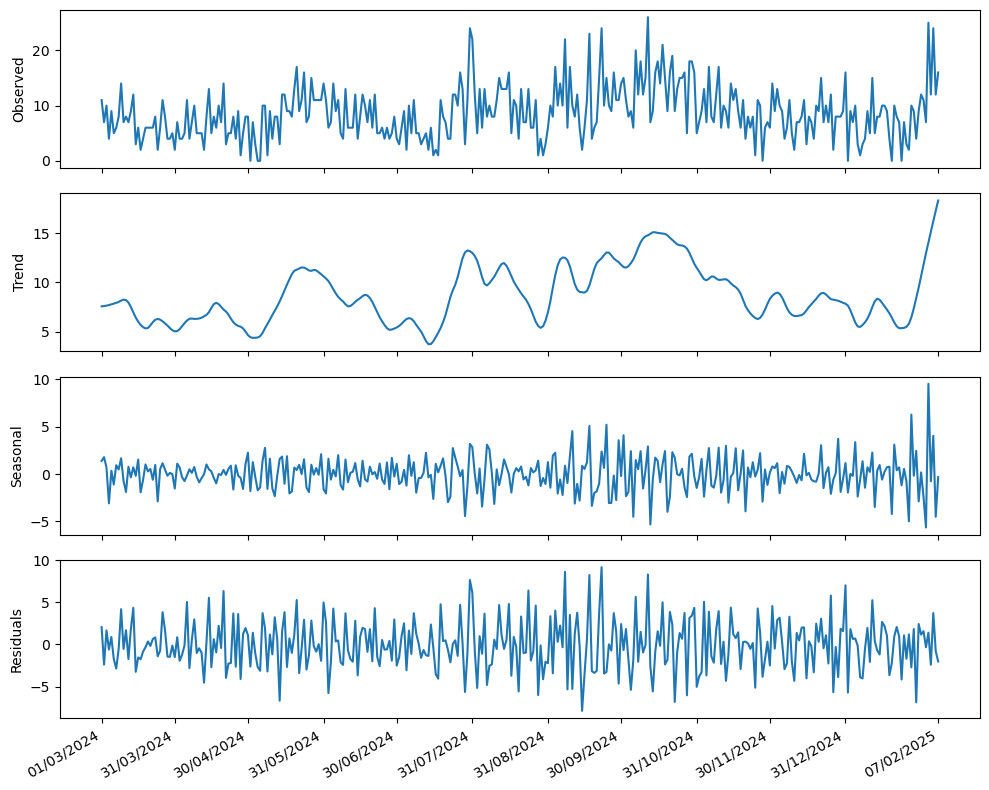

In [7]:
decomposition = STL(df['cups_sold'], period=7).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks([0,30,60,91,121,152,183,213,244,274,305,343], ['01/03/2024','31/03/2024','30/04/2024','31/05/2024','30/06/2024','31/07/2024','31/08/2024','30/09/2024','31/10/2024','30/11/2024','31/12/2024','07/02/2025'])
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('data_decomposition.png', dpi=300)

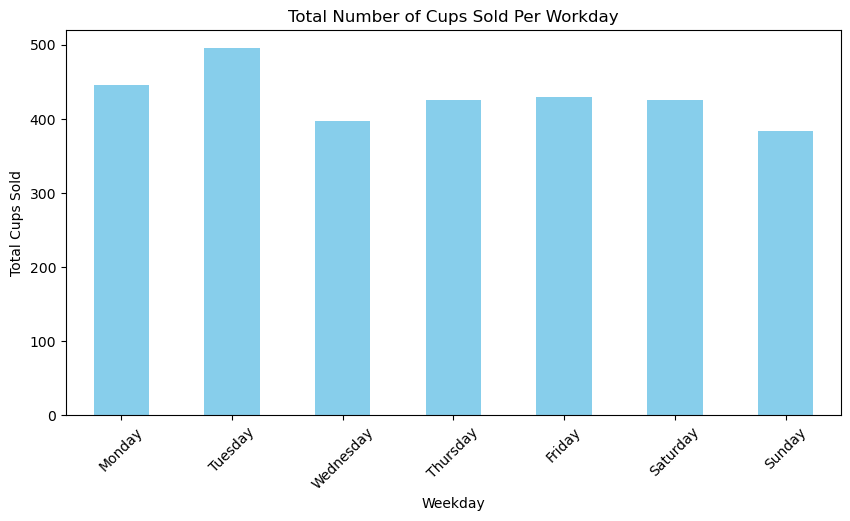

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot total number of sales for each day
plt.figure(figsize=(10, 5))
df.groupby('weekday')['cups_sold'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', color='skyblue')

plt.xlabel("Weekday")
plt.ylabel("Total Cups Sold")
plt.title("Total Number of Cups Sold Per Workday")
plt.xticks(rotation=45)
plt.show()

plt.savefig('weekday_sales.png', dpi=300)


In [15]:
target=df['cups_sold']
exog=df['weekday_num']

In [17]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.4626611918300476
p-value: 0.008999440708412203


In [19]:
p = range(0, 6, 1)
d = 0
q = range(0, 6, 1)
P = range(0, 6, 1)
D = 0
Q = range(0, 6, 1)
s = 7

In [21]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [23]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [29]:
target_train = df['cups_sold'][:-7]  

result_df = optimize_SARIMA(target_train, parameters_list, d, D, s)
result_df

  0%|          | 0/1296 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(5, 5, 0, 0)",1936.735394
1,"(3, 3, 0, 1)",1936.803180
2,"(1, 1, 0, 0)",1937.886745
3,"(5, 5, 0, 1)",1938.463672
4,"(1, 1, 0, 1)",1938.622719
...,...,...
1290,"(0, 1, 0, 1)",2242.596525
1291,"(0, 0, 0, 2)",2245.248811
1292,"(0, 1, 0, 0)",2316.266959
1293,"(0, 0, 0, 1)",2330.578473


In [31]:
best_model = SARIMAX(target_train, order=(3,0,3), seasonal_order=(0,0,1,7), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           cups_sold   No. Observations:                  337
Model:             SARIMAX(3, 0, 3)x(0, 0, [1], 7)   Log Likelihood                -960.402
Date:                             Mon, 03 Mar 2025   AIC                           1936.803
Time:                                     18:05:47   BIC                           1967.364
Sample:                                          0   HQIC                          1948.984
                                             - 337                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3532      0.046     51.668      0.000       2.264       2.442
ar.L2         -2.2294      

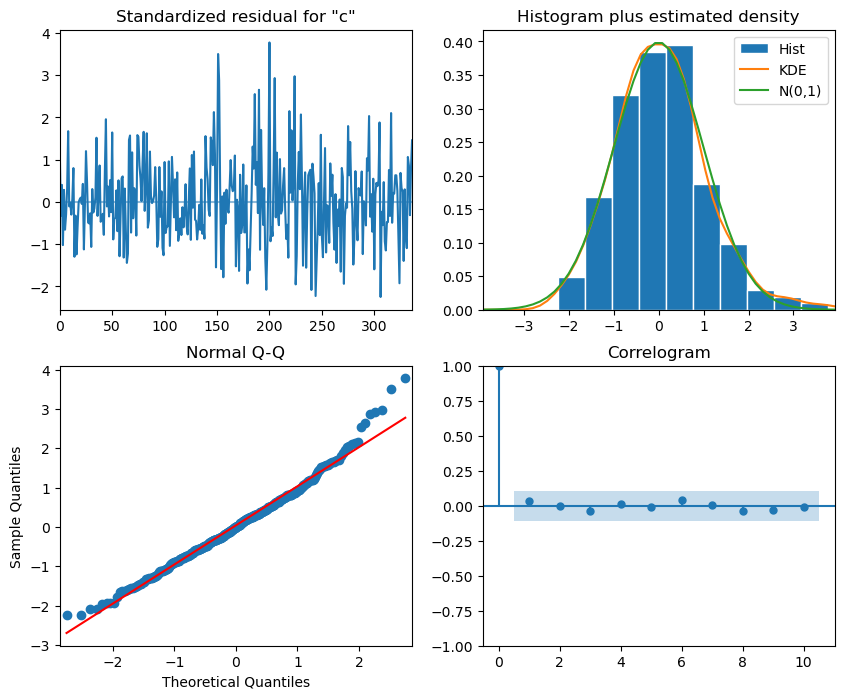

In [33]:
best_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('4graphs.png', dpi=300)

In [35]:
residuals=best_model_fit.resid
lbvalue=acorr_ljungbox(residuals,np.arange(1,11,1))
print(lbvalue)

     lb_stat  lb_pvalue
1   0.287910   0.591563
2   0.288776   0.865552
3   0.815416   0.845776
4   0.875536   0.928044
5   0.904546   0.969892
6   1.407266   0.965415
7   1.417953   0.985015
8   1.687163   0.989147
9   1.991168   0.991606
10  2.028543   0.996117


In [41]:
test = df.iloc[-7:] 
SARIMA_pred = best_model_fit.get_prediction(337, 343).predicted_mean   
test['SARIMA_pred'] = SARIMA_pred

In [43]:
test

,date,weekday,cups_sold,weekday_num,SARIMA_pred
337,2025-02-01,Saturday,11,5,7.192639
338,2025-02-02,Sunday,7,6,8.014757
339,2025-02-03,Monday,25,0,8.004984
340,2025-02-04,Tuesday,12,1,7.980671
341,2025-02-05,Wednesday,24,2,7.737216
342,2025-02-06,Thursday,12,3,6.864332
343,2025-02-07,Friday,16,4,6.267495


In [45]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
mape_SARIMA = mape(test.cups_sold, test.SARIMA_pred)

print( mape_SARIMA)

45.99576813918258


In [57]:
from sklearn.metrics import mean_squared_error

rmse_SARIMA=mean_squared_error(test.cups_sold, test.SARIMA_pred,squared=False)
print(rmse_SARIMA)

10.043378751230389


In [89]:
mae_SARIMA = mean_absolute_error(test.cups_sold, test.SARIMA_pred)

print(mae_SARIMA)

8.138203050688626


In [61]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [63]:
p = range(0, 6, 1)
d = 0
q = range(0, 6, 1)
P = range(0, 6, 1)
D = 0
Q = range(0, 6, 1)
s = 7


In [65]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [67]:
exog_train = df['weekday_num'][:-7]  

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/1296 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(5, 5, 0, 1)",1936.021911
1,"(3, 3, 1, 0)",1936.563877
2,"(3, 3, 0, 1)",1936.586385
3,"(1, 1, 0, 0)",1937.348548
4,"(1, 1, 0, 1)",1937.635906
...,...,...
1290,"(0, 3, 0, 0)",2157.954594
1291,"(0, 0, 0, 1)",2171.815587
1292,"(0, 2, 0, 0)",2180.235713
1293,"(0, 1, 0, 0)",2203.204818


In [69]:
best_model = SARIMAX(target_train, exog_train, order=(5,0,5), seasonal_order=(0,0,1,7), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           cups_sold   No. Observations:                  337
Model:             SARIMAX(5, 0, 5)x(0, 0, [1], 7)   Log Likelihood                -955.011
Date:                             Mon, 03 Mar 2025   AIC                           1936.022
Time:                                     21:14:05   BIC                           1985.683
Sample:                                          0   HQIC                          1955.816
                                             - 337                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
weekday_num    -0.1796      0.060     -3.002      0.003      -0.297      -0.062
ar.L1           0.7846  

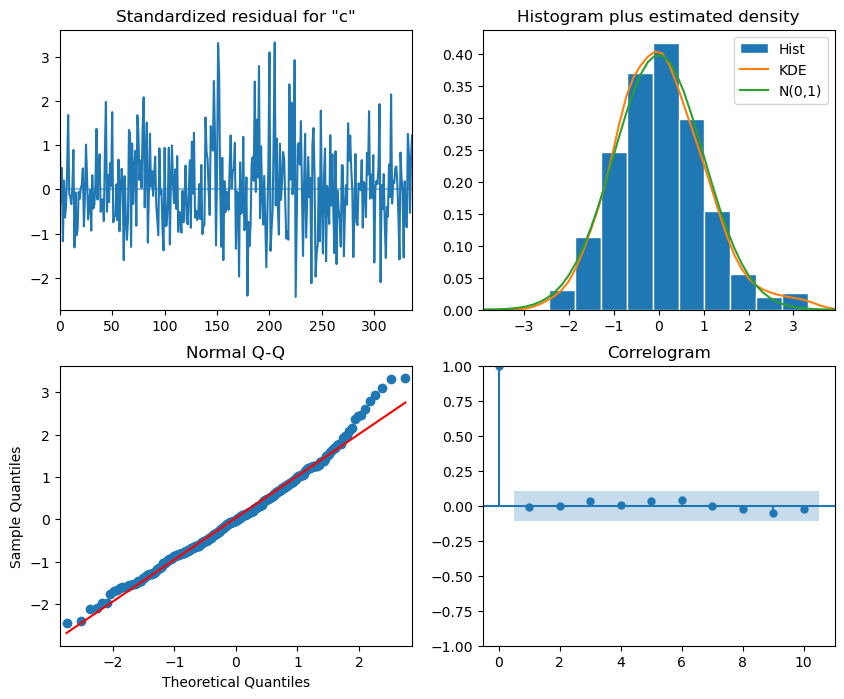

In [71]:
best_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('4graphs_SARIMAX.png', dpi=300)

In [73]:
residuals=best_model_fit.resid
lbvalue=acorr_ljungbox(residuals,np.arange(1,11,1))
print(lbvalue)

     lb_stat  lb_pvalue
1   0.054932   0.814693
2   0.059728   0.970578
3   0.298637   0.960285
4   0.316216   0.988743
5   0.645917   0.985805
6   1.206630   0.976556
7   1.206786   0.990770
8   1.271421   0.995885
9   2.219816   0.987495
10  2.465415   0.991370


In [75]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    
    
    if method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(5,0,5), seasonal_order=(0,0,1,7), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [79]:

target_test=target[-7:]
pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1


pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

test['pred_SARIMAX'] = pred_SARIMAX

test

,date,weekday,cups_sold,weekday_num,SARIMA_pred,pred_SARIMAX
337,2025-02-01,Saturday,11,5,7.192639,6.962210
338,2025-02-02,Sunday,7,6,8.014757,7.310482
339,2025-02-03,Monday,25,0,8.004984,7.773383
340,2025-02-04,Tuesday,12,1,7.980671,9.721346
341,2025-02-05,Wednesday,24,2,7.737216,11.004842
342,2025-02-06,Thursday,12,3,6.864332,12.317369
343,2025-02-07,Friday,16,4,6.267495,12.284745


In [83]:
mape_SARIMAX = mape(test.cups_sold, test.pred_SARIMAX)

print( mape_SARIMAX)

29.86420999989211


In [85]:
from sklearn.metrics import mean_squared_error

rmse_SARIMAX=mean_squared_error(test.cups_sold, test.pred_SARIMAX,squared=False)
print(rmse_SARIMAX)

8.461059858204042


In [91]:
mae_SARIMAX = mean_absolute_error(test.cups_sold, test.pred_SARIMAX)

print(mae_SARIMAX)

5.840189386384659
